# **Part1: Diffusion Models and Latent Diffusion**

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Mar  1 15:39:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Section 1: Overview of Diffusion Models

![model type diag](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png)
For an overview of different types of generative models. (read [this blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/))

The core concept behind these models is deceptively simple:
- Take a starting image
- Add some noise, iteratively degrading the image until almost nothing but noise remains.
- Train a model to 'undo' these noise steps.
- To generate, start from pure noise and repeatedly apply the model to 'denoise' our way back to a plausible image.

The model generally has access to some representation of 't' - that is, how many noise steps have been applied to the image. And to make its job easier, we typically get the model to output a prediction for the *noise* that we could subtract from the noisy image to get a less noisy one, rather than spitting out the denoised image.

# Section 2: Implemention



In [4]:
# @title Install requirements
!pip install datasets &>> install.log

In [5]:
# @title imports and utility functions

from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np


def img_to_tensor(im):
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    """
        Gather consts for `t` and reshape to feature map shape
    """
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

## 2.1 Dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


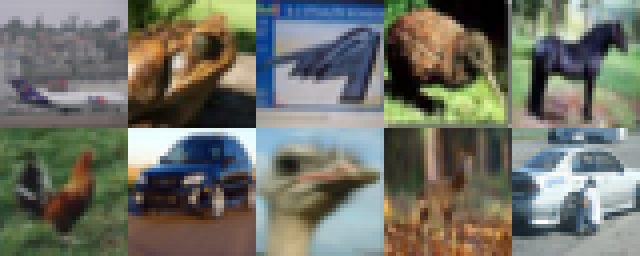

In [6]:
#@title cifar10 - 32px images in 10 classes

# Download and load the dataset
cifar10 = load_dataset('cifar10')

# View some examples:
image = Image.new('RGB', size=(32*5, 32*2))
for i in range(10):
  im = cifar10['train'][i]['img']
  image.paste(im, ( (i%5)*32, (i//5)*32 ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

In [7]:
# @title alternative dataset: faces (CelebA)
# faces = load_dataset('huggan/CelebA-faces')

## 2.2 Adding Noise
We set up a 'variance schedule' $\beta$, where $\beta_t$ specifies how much noise we want to add at that step. The formula for single noise step is:

$$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}), \
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$$

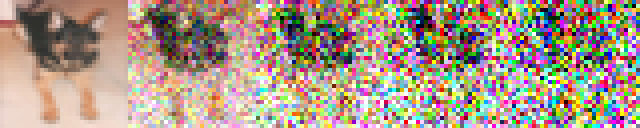

In [8]:
# import torch
from math import sqrt

n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)

def q_xt_xtminus1(xtm1, t):

    # mu = √(1-beta[t]) * x[t-1]
    mu = gather(1. - beta, t) ** 0.5 * xtm1

    # sigma = beta[t]
    sigma = gather(beta, t) ** 0.5

    # Reparameterization Trick:
    # z ~ N(mu, sigma) => z = mu + sigma * ε, where: ε ~ N(0,1)
    xt = mu + sigma * torch.randn_like(xtm1)

    return xt


# Show im at different stages
ims = []
start_im = cifar10['train'][10]['img']
x = img_to_tensor(start_im).squeeze()
for t in range(n_steps):

  # Store images every 20 steps to show progression
  if t%20 == 0:
    ims.append(tensor_to_image(x))

  # Calculate Xt given Xt-1 (i.e. x from the previous iteration)
  t = torch.tensor(t, dtype=torch.long) # t as a tensor
  x = q_xt_xtminus1(x, t) # Modify x using our function above

# Display the images
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

To train our model at different time steps easily, we need to be able to apply all noise at once. This can be done using [reparameterization trick](https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick):

$$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned},\  where :\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$$


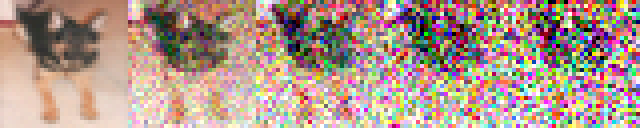

In [9]:
n_steps = 100
beta = torch.linspace(0.0001, 0.02, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):

    # mu = √(alpha_bar[t]) * x[0]
    mu = gather(alpha_bar, t) ** 0.5 * x0

    # sigma = 1 - alpha_bar[t]
    sigma = gather(1. - alpha_bar, t) ** 0.5

    # Reparameterization Trick:
    # z ~ N(mu, sigma) => z = mu + sigma * ε, where: ε ~ N(0,1)
    xt = mu + sigma * torch.randn_like(x0)

    return xt


# Show im at different stages
ims = []
start_im = cifar10['train'][10]['img']
x0 = img_to_tensor(start_im).squeeze()
for t in [0, 20, 40, 60, 80]:
  x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long))
  ims.append(tensor_to_image(x))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Note the difference: we can now calculate xt without having to do `for t in range...`.

## 2.3 Choosing a Model for Denoising

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they lose the details around exact pixel coordinates. To get around this, an architecture called the U-Net was introduced. Originally designed for segmentation tasks,  passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers.

These networks turned out to be great at all sorts of image-to-image tasks, e.g., colorization ([deoldify](https://github.com/jantic/DeOldify)), segmentation and so on. These days, typical unet models incorporate ideas such as attention and can be built around pretrained backbones like resnet-50 for transfer learning tasks.

The implementation below (taken almost verbatim from [here](https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/unet.py)) is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in, in the middle of the network.

In [10]:
#@title Unet Definition

import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

# A fancy activation function
class Swish(nn.Module):
    """
        Swish actiavation function
    """

    def forward(self, x):
        return x * torch.sigmoid(x)

# The time embedding
class TimeEmbedding(nn.Module):
    """
        Embeddings for t
    """

    def __init__(self, n_channels: int):
        """
            Args:
              n_channels: int
              Number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings

        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

# Residual blocks include 'skip' connections
class ResidualBlock(nn.Module):
    """
        A residual block has two convolution layers with group normalization.
        Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):

        """
            Args:
              in_channels: int
              Number of input channels
              out_channels: int
              Number of output channels
              time_channels: int
              Number of channels in the time step t embeddings
              n_groups: int
              Number of groups for group normalization
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):

        """
            Args:
              x: torch.tensor
              Input with the shape `[batch_size, in_channels, height, width]`
              t: torch.tensor
              Timestep with the shape `[batch_size, time_channels]`
        """

        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(t)[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.act2(self.norm2(h)))

        # Add the shortcut connection and return
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):

    """
        Attention block is similar to transformer multi-head attention
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):

        """
            Args:
              in_channels: int
              Number of input channels
              n_heads: int
              Number of heads in multi-head attention
              d_k: int
              Dimensions of each head
              n_groups: int
              Number of groups for group normalization
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
            Args:
              x: torch.Tensor
              Input with shape [batch_size, in_channels, height, width]
              t: torch.Tensor
              Timestep shape [batch_size, time_channels]
        """

        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):
    """
        This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    """
        This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    """
        It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
        This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
        Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
        Scale down the feature map
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

# The core class definition (aka the important bit)
class UNet(nn.Module):
    """
        U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
            Args:
              image_channels: int
              Number of channels in the image. 3 for RGB.
              n_channels: int
              Number of input channels in the initial feature map that we transform the image into
              ch_mults: Tuple
              List of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
              is_attn: Tuple
              List of booleans that indicate whether to use attention at each resolution
              n_blocks: int
              Number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
          Args:
            x: torch.Tensor
            Input with shape [batch_size, in_channels, height, width]
            t: torch.Tensor
            Timestep shape [batch_size]
        """
        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

In [11]:
#@title U-Net in action on dummy data:

# A dummy batch of 10 3-channel 32px images
x = torch.randn(10, 3, 32, 32)

# 't' - what timestep are we on
t = torch.tensor([50.], dtype=torch.long)

# Define the unet model
unet = UNet()

# The foreward pass (takes both x and t)
model_output = unet(x, t)

# The output shape matches the input.
model_output.shape

torch.Size([10, 3, 32, 32])

## 2.3' Data Loader

In [12]:
from torchvision import transforms
from torch.utils.data import Dataset

class MyCifar10(Dataset):
    """
        Implementation of Dataloader for Cifar10 Dataset Classification
    """

    def __init__(
        self,
        cifar10,
        data_mode,
        input_normalization = None,
        mean=(0.485, 0.456, 0.406),
        std=(0.228, 0.224, 0.225)
    ) -> None:

        #Dataloader for loading data.
        super().__init__()

        assert data_mode in [
            "train", "test"], "'data_mode' must be one of this element: ['train', 'test']."

        self.data_mode = data_mode

        # images
        self.images = cifar10[self.data_mode]["img"]

        # labels
        self.labels = cifar10[self.data_mode]["label"]


        # Normalization
        self.input_normalization = input_normalization
        self.mean, self.std = mean, std

        self.transfrom = transforms.ToTensor()
        if self.input_normalization:
            self.transfrom = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std)
            ])

    def __getitem__(self, index):
        # image
        image = self.images[index]
        image = self.transfrom(image)

        # label
        label = self.labels[index]

        return image, label

    def __len__(self):
        """
            This function returns number of data.
        """
        return len(self.images)


## 2.4 Training Time

Now we need to train it to predict the noise given $x_t$ and $t$.

Why not predict the denoised image directly? Mostly just due to convenience - the noise is nicely scaled with a mean of zero, and this is well-suited to being modeled with a neural network. We make it easy by tweaking our `q_xt_x0` function to return both the noised image $x_t$ and the noise itself, which will be the 'target' our network tries to produce.

In [13]:
import torch.nn as nn
from torch import optim

# Create the model
unet = UNet(n_channels=32).cuda()

# Set up some parameters
n_steps = 1000
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Modified to return the noise itself as well
def q_xt_x0(x0, t):

    # Reparameterization Trick: z ~ N(mu, sigma) => z = mu + sigma * ε    where    ε ~ N(0,1)

    # mu = √(alpha_bar[t]) * x[0]
    mu = gather(alpha_bar, t) ** 0.5 * x0

    # sigma = 1 - alpha_bar[t]
    sigma = gather(1. - alpha_bar, t) ** 0.5

    # ε
    noise = torch.randn_like(x0)

    xt = mu + sigma * noise

    return xt, noise

### 2.4.1 Training and Testing Data Loader

In [14]:
batch_size = 512 # Lower if hits memory issues
dataloader_num_worker = 2

# Train data loader
train_dataloader = MyCifar10(
        cifar10,
        "train",
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataloader,
    batch_size=batch_size,
    num_workers=dataloader_num_worker,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)


# test data loader
test_dataloader = MyCifar10(
        cifar10,
        "test"
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataloader,
    batch_size=batch_size,
    num_workers=dataloader_num_worker,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)

### 2.4.2 Diffusion Model Utilities

In [15]:
def sample_timesteps(num_samples):
    return torch.randint(low=1, high=n_steps, size=(num_samples,))

### 2.4.3 Utilities

In [16]:
class AverageMeter(object):
    """
        computes and stores the average and current value
    """

    def __init__(self, start_val=0, start_count=0, start_avg=0, start_sum=0):
        self.reset()
        self.val = start_val
        self.avg = start_avg
        self.sum = start_sum
        self.count = start_count

    def reset(self):
        """
            Initialize 'value', 'sum', 'count', and 'avg' with 0.
        """
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num=1):
        """
            Update 'value', 'sum', 'count', and 'avg'.
        """
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count

### 2.4.4 Training for Some Epochs

In [ ]:
from tqdm import tqdm

# Training params
lr = 2e-4

criterion = nn.MSELoss()
optimizer = optim.AdamW(unet.parameters(), lr=lr) # Optimizer

# Training Loop
num_epochs = 100
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, min_lr=1e-7) # learning rate scheduler
learning_rates = list()
losses = [] # Store losses for later plotting
cifar10_train = cifar10["train"]
cifar10_test = cifar10["test"]

unet.train()
best_loss = float('inf')

for epoch in range(num_epochs):

    # training loss
    training_loss = AverageMeter()
    t_dataloader = tqdm(train_dataloader)
    t_dataloader.set_description(f"Epoch {epoch}/{num_epochs}")

    for (images, labels) in t_dataloader:
        images = images.cuda()
        t = sample_timesteps(images.shape[0]).cuda()

        # Adding noise to the input image
        x_t, noise = q_xt_x0(images, t)

        # Predicting the noise
        predicted_noise = unet(x_t, t)

        loss = criterion(noise, predicted_noise)

        # Optimizing
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Updating average loss of current epoch
        training_loss.update(loss.item())

        # current learning rate
        # current_lr = optimizer.param_groups[0]['lr']
        current_lr = lr_scheduler.get_last_lr()[0]

        # Reporting
        t_dataloader.set_postfix(
            loss = loss.item(),
            lr = current_lr
        )

    losses.append(training_loss.avg)

    lr_scheduler.step(training_loss.avg)
    learning_rates.append(lr_scheduler.get_last_lr()[0])

    print(f"training_loss.avg:{training_loss.avg}, best_loss:{best_loss}")

    if training_loss.avg < best_loss:
        best_loss = training_loss.avg
        torch.save(unet.state_dict(), "/content/drive/My Drive/DDPM_weights.pth")  # Overwrites existing file
        print(f"Model weights updated, Epoch={epoch}")

    np.save("/content/drive/My Drive/DDPM_losses", np.array(losses))
    np.save("/content/drive/My Drive/DDPM_lr", np.array(learning_rates))

Epoch 0/100: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it, loss=0.106, lr=0.0002]


training_loss.avg:0.2628681731163239, best_loss:inf
Model weights updated, Epoch=0


Epoch 1/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0515, lr=0.0002]


training_loss.avg:0.07402165131453349, best_loss:0.2628681731163239
Model weights updated, Epoch=1


Epoch 2/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0423, lr=0.0002]


training_loss.avg:0.04759401383296567, best_loss:0.07402165131453349
Model weights updated, Epoch=2


Epoch 3/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0341, lr=0.0002]


training_loss.avg:0.03706260453149372, best_loss:0.04759401383296567
Model weights updated, Epoch=3


Epoch 4/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0249, lr=0.0002]


training_loss.avg:0.03157369049303994, best_loss:0.03706260453149372
Model weights updated, Epoch=4


Epoch 5/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.03, lr=0.0002]


training_loss.avg:0.028579947747746293, best_loss:0.03157369049303994
Model weights updated, Epoch=5


Epoch 6/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0276, lr=0.0002]


training_loss.avg:0.025760945730975697, best_loss:0.028579947747746293
Model weights updated, Epoch=6


Epoch 7/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0226, lr=0.0002]


training_loss.avg:0.02380277049176547, best_loss:0.025760945730975697
Model weights updated, Epoch=7


Epoch 8/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0249, lr=0.0002]


training_loss.avg:0.022865554222799078, best_loss:0.02380277049176547
Model weights updated, Epoch=8


Epoch 9/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0192, lr=0.0002]


training_loss.avg:0.021827311083978534, best_loss:0.022865554222799078
Model weights updated, Epoch=9


Epoch 10/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0237, lr=0.0002]


training_loss.avg:0.02085287036488251, best_loss:0.021827311083978534
Model weights updated, Epoch=10


Epoch 11/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0221, lr=0.0002]


training_loss.avg:0.02039849665966265, best_loss:0.02085287036488251
Model weights updated, Epoch=11


Epoch 12/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0209, lr=0.0002]


training_loss.avg:0.01927551203312314, best_loss:0.02039849665966265
Model weights updated, Epoch=12


Epoch 13/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0155, lr=0.0002]


training_loss.avg:0.019203200708238447, best_loss:0.01927551203312314
Model weights updated, Epoch=13


Epoch 14/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.016, lr=0.0002]


training_loss.avg:0.01885762146427011, best_loss:0.019203200708238447
Model weights updated, Epoch=14


Epoch 15/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0188, lr=0.0002]


training_loss.avg:0.018024261537179048, best_loss:0.01885762146427011
Model weights updated, Epoch=15


Epoch 16/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.017, lr=0.0002]


training_loss.avg:0.017787169883673896, best_loss:0.018024261537179048
Model weights updated, Epoch=16


Epoch 17/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0186, lr=0.0002]


training_loss.avg:0.018125523195354914, best_loss:0.017787169883673896


Epoch 18/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0163, lr=0.0002]


training_loss.avg:0.016887878219844128, best_loss:0.017787169883673896
Model weights updated, Epoch=18


Epoch 19/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0168, lr=0.0002]


training_loss.avg:0.017158400457428426, best_loss:0.016887878219844128


Epoch 20/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0181, lr=0.0002]


training_loss.avg:0.01657346835626023, best_loss:0.016887878219844128
Model weights updated, Epoch=20


Epoch 21/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.014, lr=0.0002]


training_loss.avg:0.016626412153472096, best_loss:0.01657346835626023


Epoch 22/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0172, lr=0.0002]


training_loss.avg:0.016288245410411333, best_loss:0.01657346835626023
Model weights updated, Epoch=22


Epoch 23/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0136, lr=0.0002]


training_loss.avg:0.016183037938055943, best_loss:0.016288245410411333
Model weights updated, Epoch=23


Epoch 24/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0201, lr=0.0002]


training_loss.avg:0.01635382422341072, best_loss:0.016183037938055943


Epoch 25/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0147, lr=0.0002]


training_loss.avg:0.015696108616812497, best_loss:0.016183037938055943
Model weights updated, Epoch=25


Epoch 26/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0159, lr=0.0002]


training_loss.avg:0.0154394739953687, best_loss:0.015696108616812497
Model weights updated, Epoch=26


Epoch 27/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0163, lr=0.0002]


training_loss.avg:0.015398029874706147, best_loss:0.0154394739953687
Model weights updated, Epoch=27


Epoch 28/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0159, lr=0.0002]


training_loss.avg:0.015426329080471578, best_loss:0.015398029874706147


Epoch 29/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0153, lr=0.0002]


training_loss.avg:0.015427952176150011, best_loss:0.015398029874706147


Epoch 30/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0138, lr=0.0002]


training_loss.avg:0.0153492057733998, best_loss:0.015398029874706147
Model weights updated, Epoch=30


Epoch 31/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0157, lr=0.0002]


training_loss.avg:0.015385657035726674, best_loss:0.0153492057733998


Epoch 32/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0152, lr=0.0002]


training_loss.avg:0.015176287462592733, best_loss:0.0153492057733998
Model weights updated, Epoch=32


Epoch 33/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0133, lr=0.0002]


training_loss.avg:0.015206093728846433, best_loss:0.015176287462592733


Epoch 34/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0138, lr=0.0002]


training_loss.avg:0.015299959668927655, best_loss:0.015176287462592733


Epoch 35/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0136, lr=0.0002]


training_loss.avg:0.015150328252312481, best_loss:0.015176287462592733
Model weights updated, Epoch=35


Epoch 36/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0171, lr=0.0002]


training_loss.avg:0.014700506965876842, best_loss:0.015150328252312481
Model weights updated, Epoch=36


Epoch 37/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0147, lr=0.0002]


training_loss.avg:0.014587335440577293, best_loss:0.014700506965876842
Model weights updated, Epoch=37


Epoch 38/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0151, lr=0.0002]


training_loss.avg:0.014462235070080782, best_loss:0.014587335440577293
Model weights updated, Epoch=38


Epoch 39/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0127, lr=0.0002]


training_loss.avg:0.014689697750977107, best_loss:0.014462235070080782


Epoch 40/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0135, lr=0.0002]


training_loss.avg:0.014721013548574885, best_loss:0.014462235070080782


Epoch 41/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0116, lr=0.0002]


training_loss.avg:0.01416788135218073, best_loss:0.014462235070080782
Model weights updated, Epoch=41


Epoch 42/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0171, lr=0.0002]


training_loss.avg:0.014595241361886871, best_loss:0.01416788135218073


Epoch 43/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0143, lr=0.0002]


training_loss.avg:0.014107141919358045, best_loss:0.01416788135218073
Model weights updated, Epoch=43


Epoch 44/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0156, lr=0.0002]


training_loss.avg:0.014585232115065565, best_loss:0.014107141919358045


Epoch 45/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0118, lr=0.0002]


training_loss.avg:0.014201404080175015, best_loss:0.014107141919358045


Epoch 46/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.013, lr=0.0002]


training_loss.avg:0.014430008182416156, best_loss:0.014107141919358045


Epoch 47/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0162, lr=0.0002]


training_loss.avg:0.014459848527473455, best_loss:0.014107141919358045


Epoch 48/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.016, lr=0.0002]


training_loss.avg:0.01406406277638613, best_loss:0.014107141919358045
Model weights updated, Epoch=48


Epoch 49/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0111, lr=0.0002]


training_loss.avg:0.013944130989589862, best_loss:0.01406406277638613
Model weights updated, Epoch=49


Epoch 50/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.016, lr=0.0002]


training_loss.avg:0.014145043079874344, best_loss:0.013944130989589862


Epoch 51/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0127, lr=0.0002]


training_loss.avg:0.013863451142168167, best_loss:0.013944130989589862
Model weights updated, Epoch=51


Epoch 52/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0155, lr=0.0002]


training_loss.avg:0.014140205163204548, best_loss:0.013863451142168167


Epoch 53/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0156, lr=0.0002]


training_loss.avg:0.014331587571270612, best_loss:0.013863451142168167


Epoch 54/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.016, lr=0.0002]


training_loss.avg:0.014055051831338478, best_loss:0.013863451142168167


Epoch 55/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0153, lr=0.0002]


training_loss.avg:0.014004846236535482, best_loss:0.013863451142168167


Epoch 56/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0189, lr=0.0002]


training_loss.avg:0.013728096967144889, best_loss:0.013863451142168167
Model weights updated, Epoch=56


Epoch 57/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0125, lr=0.0002]


training_loss.avg:0.013606901926805779, best_loss:0.013728096967144889
Model weights updated, Epoch=57


Epoch 58/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0128, lr=0.0002]


training_loss.avg:0.013939915909146776, best_loss:0.013606901926805779


Epoch 59/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0162, lr=0.0002]


training_loss.avg:0.013650796053056814, best_loss:0.013606901926805779


Epoch 60/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0139, lr=0.0002]


training_loss.avg:0.013745533587525085, best_loss:0.013606901926805779


Epoch 61/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0169, lr=0.0002]


training_loss.avg:0.013741757112498186, best_loss:0.013606901926805779


Epoch 62/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0133, lr=0.0002]


training_loss.avg:0.013494975769854322, best_loss:0.013606901926805779
Model weights updated, Epoch=62


Epoch 63/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0137, lr=0.0002]


training_loss.avg:0.013793090652978542, best_loss:0.013494975769854322


Epoch 64/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0179, lr=0.0002]


training_loss.avg:0.013799995316990785, best_loss:0.013494975769854322


Epoch 65/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0158, lr=0.0002]


training_loss.avg:0.013889682650261996, best_loss:0.013494975769854322


Epoch 66/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.015, lr=0.0002]


training_loss.avg:0.01369504110735594, best_loss:0.013494975769854322


Epoch 67/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0113, lr=0.0002]


training_loss.avg:0.013845134716556996, best_loss:0.013494975769854322


Epoch 68/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0146, lr=0.0002]


training_loss.avg:0.013722245068270333, best_loss:0.013494975769854322


Epoch 69/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0108, lr=2e-5]


training_loss.avg:0.0136828818263448, best_loss:0.013494975769854322


Epoch 70/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0124, lr=2e-5]


training_loss.avg:0.01329771331416405, best_loss:0.013494975769854322
Model weights updated, Epoch=70


Epoch 71/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0142, lr=2e-5]


training_loss.avg:0.01338139824493199, best_loss:0.01329771331416405


Epoch 72/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.00988, lr=2e-5]


training_loss.avg:0.013626479401196144, best_loss:0.01329771331416405


Epoch 73/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0126, lr=2e-5]


training_loss.avg:0.013358396107368931, best_loss:0.01329771331416405


Epoch 74/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0148, lr=2e-5]


training_loss.avg:0.012994041029667976, best_loss:0.01329771331416405
Model weights updated, Epoch=74


Epoch 75/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0146, lr=2e-5]


training_loss.avg:0.013467744439460185, best_loss:0.012994041029667976


Epoch 76/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0128, lr=2e-5]


training_loss.avg:0.013377808880212963, best_loss:0.012994041029667976


Epoch 77/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0129, lr=2e-5]


training_loss.avg:0.013239510651981952, best_loss:0.012994041029667976


Epoch 78/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0133, lr=2e-5]


training_loss.avg:0.013319668274524868, best_loss:0.012994041029667976


Epoch 79/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0144, lr=2e-5]


training_loss.avg:0.013458465701159167, best_loss:0.012994041029667976


Epoch 80/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0131, lr=2e-5]


training_loss.avg:0.012959932784873004, best_loss:0.012994041029667976
Model weights updated, Epoch=80


Epoch 81/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0158, lr=2e-5]


training_loss.avg:0.013196018267879072, best_loss:0.012959932784873004


Epoch 82/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0126, lr=2e-5]


training_loss.avg:0.013218945510001207, best_loss:0.012959932784873004


Epoch 83/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0145, lr=2e-5]


training_loss.avg:0.013445308793108074, best_loss:0.012959932784873004


Epoch 84/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0123, lr=2e-5]


training_loss.avg:0.01356901077325551, best_loss:0.012959932784873004


Epoch 85/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0132, lr=2e-5]


training_loss.avg:0.013665212726942738, best_loss:0.012959932784873004


Epoch 86/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0124, lr=2e-5]


training_loss.avg:0.013701574658328781, best_loss:0.012959932784873004


Epoch 87/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0168, lr=2e-6]


training_loss.avg:0.013451101467469516, best_loss:0.012959932784873004


Epoch 88/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0142, lr=2e-6]


training_loss.avg:0.013239886174548646, best_loss:0.012959932784873004


Epoch 89/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0143, lr=2e-6]


training_loss.avg:0.013604242905822336, best_loss:0.012959932784873004


Epoch 90/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0144, lr=2e-6]


training_loss.avg:0.013445501320292147, best_loss:0.012959932784873004


Epoch 91/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0127, lr=2e-6]


training_loss.avg:0.013364947210921317, best_loss:0.012959932784873004


Epoch 92/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.00931, lr=2e-6]


training_loss.avg:0.01320009115057028, best_loss:0.012959932784873004


Epoch 93/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.013, lr=2e-7]


training_loss.avg:0.013270583973095124, best_loss:0.012959932784873004


Epoch 94/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0154, lr=2e-7]


training_loss.avg:0.013431697665732734, best_loss:0.012959932784873004


Epoch 95/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.013, lr=2e-7]


training_loss.avg:0.013467217966610072, best_loss:0.012959932784873004


Epoch 96/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.00989, lr=2e-7]


training_loss.avg:0.01340066215821675, best_loss:0.012959932784873004


Epoch 97/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0109, lr=2e-7]


training_loss.avg:0.013194598979791817, best_loss:0.012959932784873004


Epoch 98/100: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it, loss=0.0132, lr=2e-7]


training_loss.avg:0.013357166058326863, best_loss:0.012959932784873004


Epoch 99/100: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it, loss=0.0146, lr=1e-7]

training_loss.avg:0.013585893047631395, best_loss:0.012959932784873004



### 2.4.5 Plotting Losses

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(losses, start_epoch=0, saving_path=None, y_precision=1):
    # epochs
    num_epochs = len(losses)
    epochs = np.arange(start_epoch, start_epoch + num_epochs, 1)


    # axis
    ax = plt.figure(figsize=(10,8)).add_subplot(111)

    # plotting (epoch, loss(epoch))
    plt.plot(np.arange(num_epochs), losses, zorder=5, linewidth=4, color="#b24238")

    # xticks
    x_min, x_max = np.min(epochs), np.max(epochs)
    xticks_step = int((x_max - x_min + 1) / 10)
    plt.xticks(np.arange(x_min, x_max + xticks_step/2, xticks_step), fontsize=12)

    # yticks
    y_min, y_max = round(min(losses), y_precision), round(max(losses), y_precision)
    yticks_step = (y_max - y_min) / 10

    plt.yticks( np.arange(y_min, y_max + yticks_step/2, yticks_step), fontsize=12)

    # xlabel
    plt.xlabel("Epoch", fontsize=25)

    # ylabel
    plt.ylabel("Loss", fontsize=25)

    # remove top and right borders
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # grid
    plt.grid(alpha=0.3, zorder=0)

    # title
    plt.title("Training Loss", fontsize=30)

    if saving_path is not None:
      plt.savefig(saving_path)

    # showing plot
    plt.show()

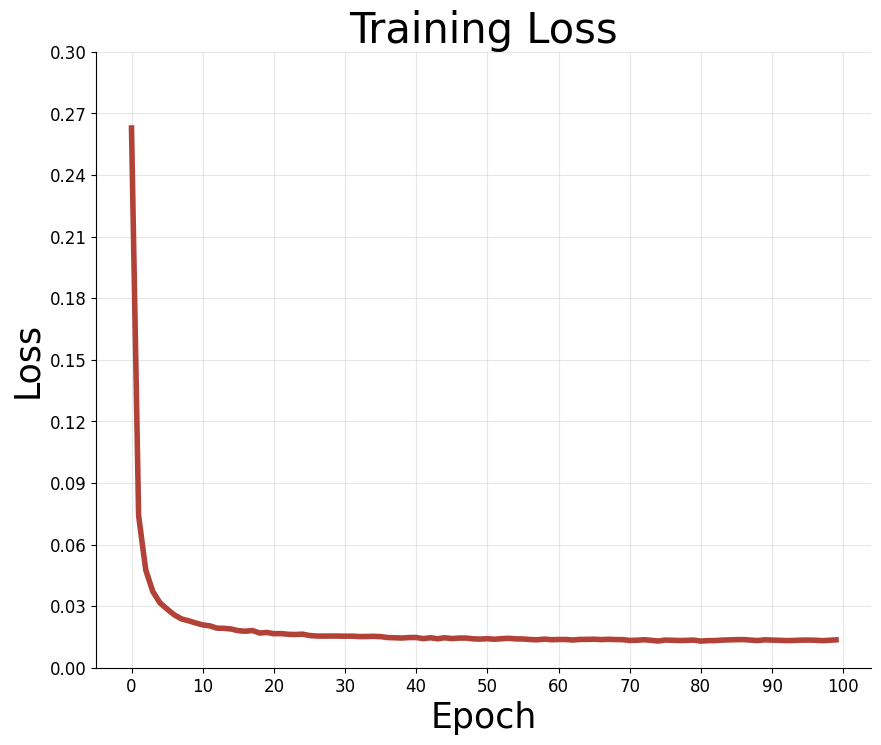

In [ ]:
plot_loss(losses, saving_path="/content/drive/My Drive/training_loss.png")

## 2.5 The Reverse Step

We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that (hopefully) looks like a real image:

In [19]:
def p_xt(xt, noise, t):

    alpha_t = gather(alpha, t)
    alpha_bar_t = gather(alpha_bar, t)
    beta_t = gather(beta, t)

    noise_coef = (1 - alpha_t) / (1 - alpha_bar_t)**0.5

    mu = 1 / (alpha_t**0.5) * (xt - noise_coef * noise)

    sigma = beta_t ** 0.5

    epsilon = torch.randn_like(xt)

    xtm1 = mu + sigma * epsilon

    return xtm1


In [ ]:
!mkdir "./DDPM_steps_samples"

In [20]:
import matplotlib.gridspec as gridspec


def plot_images(imgs,figsize=(20,20)):
    num_of_images = imgs.shape[0]
    cols = int(np.ceil(num_of_images/2))
    rows = 2
    plt.rcParams["figure.figsize"] = figsize
    plt.rcParams["figure.autolayout"] = True
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(wspace=0.5, hspace=0.1)
    fig, ax = plt.subplots(rows,cols)
    t=0
#     traspose_channels_images = ims
    for i in range(rows):
        for j in range(cols):
            ax[i,j].imshow(imgs[t].cpu().numpy().transpose((1,2,0)),cmap='gray')
            ax[i,j].set_aspect('equal')
            ax[i,j].set_xticklabels([])
            ax[i,j].set_yticklabels([])

            ax[i,j].spines["top"].set_visible(False)
            ax[i,j].spines["right"].set_visible(False)
            ax[i,j].spines["bottom"].set_visible(False)
            ax[i,j].spines["left"].set_visible(False)

            plt.setp(ax[i,j].get_xticklabels(), visible=False)
            plt.setp(ax[i,j].get_yticklabels(), visible=False)
            ax[i,j].tick_params(axis='both', which='both', length=0)

            t+=1
    plt.tight_layout()
    plt.show()

step: 999
step: 512
step: 256
step: 64
step: 16
step: 4
step: 0


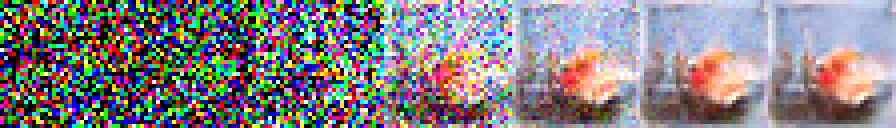

In [ ]:
from torchvision.utils import save_image

x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise
ims = []

desired_stages = [0, 4, 16, 64, 256, 512, 999]
desired_stages = [999-stage for stage in desired_stages]

# Reverse step loop
_ts = list()

for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

    if i in desired_stages:
        print(f"step: {999-i}")

        save_image(x[0], f"./DDPM_steps_samples/{999-i}.png")

        ims.append(Image.open(f"./DDPM_steps_samples/{999-i}.png"))

num_images= len(desired_stages)
image = Image.new('RGB', size=(32*num_images, 32))
for i, im in enumerate(ims[:num_images]):
  image.paste(im, ((i%num_images)*32, 0))
image.resize((32*4*num_images, 32*4), Image.NEAREST)

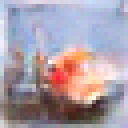

In [ ]:
ims[-1].resize((32*4, 32*4), Image.NEAREST)

In [ ]:
!mkdir "./DDPM_some_samples"

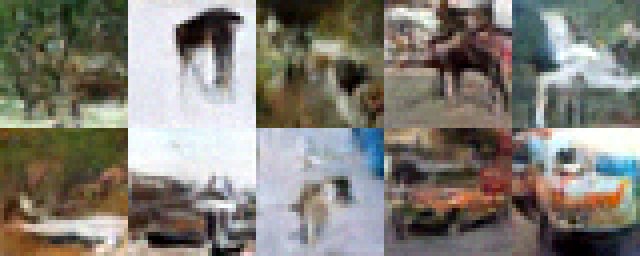

In [ ]:
#@title Make and show 10 examples:
x = torch.randn(10, 3, 32, 32).cuda() # Start with random noise
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

for i in range(10):

    #save_image(x[i], f"./DDPM_some_samples/{i}.png")
    ims.append(Image.open(f"./DDPM_some_samples/{i}.png"))

image = Image.new('RGB', size=(32*5, 32*2))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 32*(i//5)))
image.resize((32*4*5, 32*4*2), Image.NEAREST)



# **Part2: Evaluating The Generated Samples With FID Score:**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import gdown

# file download
gdown.download(id="1s4Dt3j4gcJ5DQorEPeRT42rHQiNktWRP", output="./DDPM_weights.pth", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1s4Dt3j4gcJ5DQorEPeRT42rHQiNktWRP
From (redirected): https://drive.google.com/uc?id=1s4Dt3j4gcJ5DQorEPeRT42rHQiNktWRP&confirm=t&uuid=c5f93db1-6da8-4afa-a290-3218afddf50c
To: /content/DDPM_weights.pth
100%|██████████| 169M/169M [00:03<00:00, 54.0MB/s]


'./DDPM_weights.pth'

In [17]:
unet.load_state_dict(torch.load("./DDPM_weights.pth", weights_only=True))

<All keys matched successfully>

In [17]:
!pip install pytorch-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Generate and Save Samples

In [21]:
!mkdir "./reverse_process"

In [24]:
from torchvision.utils import save_image
from tqdm import tqdm

# generate samples
num_samples = 100

for k in tqdm(range(num_samples)):
    x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise
    for i in range(n_steps):

        with torch.no_grad():
            t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
            pred_noise = unet(x.float(), t.unsqueeze(0))
            x = p_xt(x, pred_noise, t.unsqueeze(0))

#             if i % 10 == 0:
#                 save_image(x, f"./outputs_backward/{k}_{i}.png")
        save_image(x, f"./reverse_process/{k}_final.png")

    # saving the generated sample (x) in a directory
    # See this link: https://pytorch.org/vision/stable/generated/torchvision.utils.save_image.html

100%|██████████| 100/100 [31:07<00:00, 18.68s/it]


In [26]:
!unzip -o "./test_samples.zip" -d "./"

Archive:  ./test_samples.zip
  inflating: ./test_samples/25.png   
  inflating: ./test_samples/70.png   
  inflating: ./test_samples/9.png    
  inflating: ./test_samples/21.png   
  inflating: ./test_samples/76.png   
  inflating: ./test_samples/90.png   
  inflating: ./test_samples/77.png   
  inflating: ./test_samples/31.png   
  inflating: ./test_samples/20.png   
  inflating: ./test_samples/36.png   
  inflating: ./test_samples/3.png    
  inflating: ./test_samples/22.png   
  inflating: ./test_samples/10.png   
  inflating: ./test_samples/57.png   
  inflating: ./test_samples/43.png   
  inflating: ./test_samples/88.png   
  inflating: ./test_samples/7.png    
  inflating: ./test_samples/79.png   
  inflating: ./test_samples/38.png   
  inflating: ./test_samples/58.png   
  inflating: ./test_samples/4.png    
  inflating: ./test_samples/85.png   
  inflating: ./test_samples/40.png   
  inflating: ./test_samples/42.png   
  inflating: ./test_samples/17.png   
  inflating: ./test_s

Compute the FID Score

In [ ]:
# to compute the FID score using pytorch-fid package,
# we need to have two image directories:
# 1- Directory of the original images.
# 2- Directory of the generated images.

# python -m pytorch_fid path/to/dataset1 path/to/dataset2 --device cuda:0

In [27]:
!python -m pytorch_fid "./test_samples" "./reverse_process" --device "cuda:0"

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:02<00:00, 37.9MB/s]
100% 2/2 [00:00<00:00,  2.21it/s]
100% 2/2 [00:00<00:00,  3.98it/s]
FID:  250.96226868998195
